In [3]:
import pandas as pd

In [4]:
#medicare_2019 = pd.read_csv("/Users/zainabshafi/Desktop/Project_1/Medicare_Hospital_Spending_by_Claim_2019.csv",encoding='utf-8')

medicare_2019 = pd.read_csv("Resources/Medicare_Hospital_Spending_by_Claim_2019.csv",encoding='utf-8')


In [5]:
#medicare_2020 = pd.read_csv("/Users/zainabshafi/Desktop/Project_1/Medicare_Hospital_Spending_by_Claim_2020.csv",encoding='utf-8')

medicare_2020 = pd.read_csv("Resources/Medicare_Hospital_Spending_by_Claim_2020.csv",encoding='utf-8')

In [6]:
#medicare_2021 = pd.read_csv("/Users/zainabshafi/Desktop/Project_1/Medicare_Hospital_Spending_by_Claim_2021.csv", encoding='utf-8')

medicare_2021 = pd.read_csv("Resources/Medicare_Hospital_Spending_by_Claim_2021.csv",encoding='utf-8')

In [7]:
#medicare_2022 = pd.read_csv("/Users/zainabshafi/Desktop/Project_1/Medicare_Hospital_Spending_by_Claim_2022.csv", encoding='utf-8')

medicare_2022 = pd.read_csv("Resources/Medicare_Hospital_Spending_by_Claim_2022.csv",encoding='utf-8')

In [14]:
#experimenting with 2020 
medicare_2020.dtypes

Facility Name                object
Facility ID                   int64
State                        object
Period                       object
Claim Type                   object
Avg Spndg Per EP Hospital     int64
Avg Spndg Per EP State        int64
Avg Spndg Per EP National     int64
Percent of Spndg Hospital    object
Percent of Spndg State       object
Percent of Spndg National    object
Start Date                   object
End Date                     object
dtype: object

In [ ]:
medicare_2020.dropna() #no null values

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,0,17,12,0.00%,0.08%,0.05%,07/01/2020,12/31/2020
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,0,1,1,0.00%,0.00%,0.00%,07/01/2020,12/31/2020
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,0,9,6,0.00%,0.04%,0.03%,07/01/2020,12/31/2020
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,154,116,179,0.62%,0.54%,0.80%,07/01/2020,12/31/2020
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,0,3,6,0.00%,0.02%,0.03%,07/01/2020,12/31/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55237,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Outpatient,756,817,845,3.21%,3.35%,3.75%,07/01/2020,12/31/2020
55238,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Skilled Nursing Facility,1049,2460,2760,4.46%,10.08%,12.25%,07/01/2020,12/31/2020
55239,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Durable Medical Equipment,178,117,105,0.76%,0.48%,0.47%,07/01/2020,12/31/2020
55240,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Carrier,1500,1437,1190,6.37%,5.89%,5.28%,07/01/2020,12/31/2020


In [ ]:
insurance_type_ct = medicare_2020["Claim Type"].unique()
print(insurance_type_ct)

['Home Health Agency' 'Hospice' 'Inpatient' 'Outpatient'
 'Skilled Nursing Facility' 'Durable Medical Equipment' 'Carrier' 'Total']


In [ ]:
#Hospital Insurance: inpatient care (in hospitals), skilled nursing facility care, hospice care, home health care.
#Medical Insurance: Outpatient care, Home health care, Durable medical equipment

In [ ]:
num_2019_rows = medicare_2019['Facility Name'].count()
num_2020_rows = medicare_2020 ['Facility Name'].count()
num_2020_rows = medicare_2021['Facility Name'].count()
num_2022_rows = medicare_2022['Facility Name'].count()


print("YR 2019 rows:",num_2019_rows,",YR 2020 rows:",num_2020_rows,",YR 2022 rows:",num_2022_rows)
#checking row count

YR 2019 rows: 67386 ,YR 2020 rows: 66506 ,YR 2022 rows: 65890


In [ ]:
#experimenting with by state spending
state_spending_19= medicare_2019.groupby("State").agg({
    "Avg Spndg Per EP Hospital": "sum",
    "Avg Spndg Per EP State" : "sum", 
    "Avg Spndg Per EP National" : "sum"
})

In [ ]:
state_spending_20= medicare_2020.groupby("State").agg({
    "Avg Spndg Per EP Hospital": "sum",
    "Avg Spndg Per EP State" : "sum", 
    "Avg Spndg Per EP National" : "sum"
})


In [ ]:
state_spending_21= medicare_2021.groupby("State").agg({
    "Avg Spndg Per EP Hospital": "sum",
    "Avg Spndg Per EP State" : "sum", 
    "Avg Spndg Per EP National" : "sum"
})


In [ ]:
state_spending_22= medicare_2022.groupby("State").agg({
      "Avg Spndg Per EP Hospital": "sum",
    "Avg Spndg Per EP State" : "sum", 
    "Avg Spndg Per EP National" : "sum"
})


In [ ]:
#Start merges

In [ ]:
insurance_claims_merge_1 = pd.merge(medicare_2019, medicare_2020, how='outer')
insurance_claims_merge_2 = pd.merge(insurance_claims_merge_1, medicare_2021, how='outer')
insurance_claims_merged = pd.merge(insurance_claims_merge_2, medicare_2022, how='outer')

In [ ]:
insurance_claims_merged.tail()

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
255019,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Outpatient,137,871,957,0.70%,3.12%,3.70%,01/01/2022,12/31/2022
255020,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Skilled Nursing Facility,874,3151,3757,4.47%,11.30%,14.54%,01/01/2022,12/31/2022
255021,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Durable Medical Equipment,51,144,126,0.26%,0.52%,0.49%,01/01/2022,12/31/2022
255022,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Carrier,1483,1749,1449,7.58%,6.27%,5.61%,01/01/2022,12/31/2022
255023,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,Complete Episode,Total,19554,27898,25828,100.0%,100.0%,100.0%,01/01/2022,12/31/2022


In [ ]:
insurance_claims_merged.to_csv('/Users/zainabshafi/Desktop/Project_1/insurance_claims_merged.csv', sep=',', index=True, encoding='utf-8')


In [ ]:
state_spending_merge = insurance_claims_merged.groupby("State").agg({
    "Avg Spndg Per EP Hospital": "sum",
    "Avg Spndg Per EP State" : "sum", 
    "Avg Spndg Per EP National" : "sum"
})
state_spending_merge.head(56) 

,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National
State,,,
AK,1193939,1422766,1473837
AL,10994177,12564265,13130786
AR,7499429,8254449,8215845
AZ,10215633,11054723,11039162
CA,51051501,52743304,51008497
CO,9206251,9619413,9168111
CT,4627721,4901369,4887102
DC,1192114,1185162,1139184
DE,1085236,1185162,1139184


In [ ]:
#just total all 4 years
total_df = insurance_claims_merged[insurance_claims_merged['Claim Type'].str.contains('total', case=False)]
total_df.head()


,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
21,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,Complete Episode,Total,23933,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
43,MARSHALL MEDICAL CENTERS,10005,AL,Complete Episode,Total,19220,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
65,NORTH ALABAMA MEDICAL CENTER,10006,AL,Complete Episode,Total,21579,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
87,MIZELL MEMORIAL HOSPITAL,10007,AL,Complete Episode,Total,17180,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
109,CRENSHAW COMMUNITY HOSPITAL,10008,AL,Complete Episode,Total,16139,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019


In [ ]:
#without total all 4 years 
keywords = ['Home Health Agency', 'Hospice', 'Inpatient', 'Outpatient', 'Skilled Nursing Facility', 'Durable Medical Equipment', 'Carrier']
condition = '|'.join(keywords)
insurance_claims_new = insurance_claims_merged[insurance_claims_merged['Claim Type'].str.contains(condition, case=True)]
insurance_claims_new.head(35)


,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
0,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,21,17,12,0.09%,0.08%,0.06%,01/01/2019,12/31/2019
1,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1,1,1,0.00%,0.00%,0.00%,01/01/2019,12/31/2019
2,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,5,8,7,0.02%,0.04%,0.03%,01/01/2019,12/31/2019
3,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,228,119,162,0.95%,0.56%,0.73%,01/01/2019,12/31/2019
4,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,2,2,3,0.01%,0.01%,0.01%,01/01/2019,12/31/2019
5,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Durable Medical Equipment,10,9,8,0.04%,0.04%,0.04%,01/01/2019,12/31/2019
6,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Carrier,594,558,605,2.48%,2.63%,2.72%,01/01/2019,12/31/2019
7,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Home Health Agency,0,0,0,0.00%,0.00%,0.00%,01/01/2019,12/31/2019
8,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Hospice,0,0,0,0.00%,0.00%,0.00%,01/01/2019,12/31/2019
9,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11021,10037,10475,46.05%,47.36%,47.16%,01/01/2019,12/31/2019


In [ ]:
#state all claim totals, without 'total'
state_spending = insurance_claims_new.groupby("State").agg({
    "Avg Spndg Per EP Hospital": "sum",
    "Avg Spndg Per EP State" : "sum", 
    "Avg Spndg Per EP National" : "sum"
})
state_spending.head(56) 


,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National
State,,,
AK,596968,711359,736918
AL,5497111,6282232,6565373
AR,3749711,4127184,4107921
AZ,5107810,5527407,5519577
CA,25525716,26371410,25504226
CO,4603127,4809659,4584054
CT,2313849,2450698,2443550
DC,596057,592572,569592
DE,542616,592572,569592


In [ ]:
#just totals for 2019
total_df_2019 = insurance_claims_2019[insurance_claims_2019['Claim Type'].str.contains('total', case=False)]
total_df_2019.head(25)

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
21,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,Complete Episode,Total,23933,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
43,MARSHALL MEDICAL CENTERS,10005,AL,Complete Episode,Total,19220,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
65,NORTH ALABAMA MEDICAL CENTER,10006,AL,Complete Episode,Total,21579,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
87,MIZELL MEMORIAL HOSPITAL,10007,AL,Complete Episode,Total,17180,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
109,CRENSHAW COMMUNITY HOSPITAL,10008,AL,Complete Episode,Total,16139,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
131,ST. VINCENT'S EAST,10011,AL,Complete Episode,Total,22378,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
153,DEKALB REGIONAL MEDICAL CENTER,10012,AL,Complete Episode,Total,18323,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
175,SHELBY BAPTIST MEDICAL CENTER,10016,AL,Complete Episode,Total,22657,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
197,HELEN KELLER HOSPITAL,10019,AL,Complete Episode,Total,19686,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019
219,DALE MEDICAL CENTER,10021,AL,Complete Episode,Total,17381,21192,22212,100.0%,100.0%,100.0%,01/01/2019,12/31/2019


In [ ]:
#2019 dataset without 'Total'
keywords = ['Home Health Agency', 'Hospice', 'Inpatient', 'Outpatient', 'Skilled Nursing Facility', 'Durable Medical Equipment', 'Carrier']
condition = '|'.join(keywords)
no_total_2019= medicare_2019[medicare_2019['Claim Type'].str.contains(condition, case=True)]
no_total_2019

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
0,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,21,17,12,0.09%,0.08%,0.06%,01/01/2019,12/31/2019
1,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1,1,1,0.00%,0.00%,0.00%,01/01/2019,12/31/2019
2,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,5,8,7,0.02%,0.04%,0.03%,01/01/2019,12/31/2019
3,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,228,119,162,0.95%,0.56%,0.73%,01/01/2019,12/31/2019
4,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,2,2,3,0.01%,0.01%,0.01%,01/01/2019,12/31/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67380,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,1 through 30 days After Discharge from Index H...,Inpatient,1582,4240,2940,9.24%,17.79%,13.24%,01/01/2019,12/31/2019
67381,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,1 through 30 days After Discharge from Index H...,Outpatient,685,867,891,4.00%,3.64%,4.01%,01/01/2019,12/31/2019
67382,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,1 through 30 days After Discharge from Index H...,Skilled Nursing Facility,2509,2939,3220,14.65%,12.33%,14.50%,01/01/2019,12/31/2019
67383,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,1 through 30 days After Discharge from Index H...,Durable Medical Equipment,26,104,95,0.15%,0.44%,0.43%,01/01/2019,12/31/2019


In [ ]:
#2020 dataset without total
keywords = ['Home Health Agency', 'Hospice', 'Inpatient', 'Outpatient', 'Skilled Nursing Facility', 'Durable Medical Equipment', 'Carrier']
condition = '|'.join(keywords)
no_total_2020= medicare_2020[medicare_2020['Claim Type'].str.contains(condition, case=True)]
no_total_2020

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,0,17,12,0.00%,0.08%,0.05%,07/01/2020,12/31/2020
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,0,1,1,0.00%,0.00%,0.00%,07/01/2020,12/31/2020
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,0,9,6,0.00%,0.04%,0.03%,07/01/2020,12/31/2020
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,154,116,179,0.62%,0.54%,0.80%,07/01/2020,12/31/2020
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,0,3,6,0.00%,0.02%,0.03%,07/01/2020,12/31/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55236,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Inpatient,5159,4354,2947,21.92%,17.84%,13.08%,07/01/2020,12/31/2020
55237,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Outpatient,756,817,845,3.21%,3.35%,3.75%,07/01/2020,12/31/2020
55238,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Skilled Nursing Facility,1049,2460,2760,4.46%,10.08%,12.25%,07/01/2020,12/31/2020
55239,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Durable Medical Equipment,178,117,105,0.76%,0.48%,0.47%,07/01/2020,12/31/2020


In [ ]:
#2021 dataset without total 
keywords = ['Home Health Agency', 'Hospice', 'Inpatient', 'Outpatient', 'Skilled Nursing Facility', 'Durable Medical Equipment', 'Carrier']
condition = '|'.join(keywords)
no_total_2021= medicare_2021[medicare_2021['Claim Type'].str.contains(condition, case=True)]
no_total_2021

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,22,16,13,0.09%,0.07%,0.05%,1/1/21,12/31/21
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1,1,1,0.00%,0.00%,0.00%,1/1/21,12/31/21
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,4,7,8,0.02%,0.03%,0.03%,1/1/21,12/31/21
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,127,118,187,0.51%,0.50%,0.77%,1/1/21,12/31/21
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,2,3,6,0.01%,0.01%,0.02%,1/1/21,12/31/21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66500,TEXAS HEALTH HOSPITAL MANSFIELD,670309,TX,1 through 30 days After Discharge from Index H...,Inpatient,3833,5210,3479,16.75%,19.75%,14.28%,1/1/21,12/31/21
66501,TEXAS HEALTH HOSPITAL MANSFIELD,670309,TX,1 through 30 days After Discharge from Index H...,Outpatient,676,845,920,2.95%,3.20%,3.78%,1/1/21,12/31/21
66502,TEXAS HEALTH HOSPITAL MANSFIELD,670309,TX,1 through 30 days After Discharge from Index H...,Skilled Nursing Facility,3287,2863,3345,14.36%,10.85%,13.73%,1/1/21,12/31/21
66503,TEXAS HEALTH HOSPITAL MANSFIELD,670309,TX,1 through 30 days After Discharge from Index H...,Durable Medical Equipment,147,121,112,0.64%,0.46%,0.46%,1/1/21,12/31/21


In [ ]:
#2022 dataset without total
keywords = ['Home Health Agency', 'Hospice', 'Inpatient', 'Outpatient', 'Skilled Nursing Facility', 'Durable Medical Equipment', 'Carrier']
condition = '|'.join(keywords)
no_total_2022= medicare_2022[medicare_2022['Claim Type'].str.contains(condition, case=True)]
no_total_2022

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,33,23,18,0.12%,0.09%,0.07%,01/01/2022,12/31/2022
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1,1,1,0.00%,0.01%,0.00%,01/01/2022,12/31/2022
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,64,38,42,0.24%,0.15%,0.16%,01/01/2022,12/31/2022
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,161,126,182,0.61%,0.51%,0.71%,01/01/2022,12/31/2022
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,10,11,16,0.04%,0.05%,0.06%,01/01/2022,12/31/2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65884,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Inpatient,7233,5895,3955,36.99%,21.13%,15.31%,01/01/2022,12/31/2022
65885,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Outpatient,137,871,957,0.70%,3.12%,3.70%,01/01/2022,12/31/2022
65886,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Skilled Nursing Facility,874,3151,3757,4.47%,11.30%,14.54%,01/01/2022,12/31/2022
65887,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Durable Medical Equipment,51,144,126,0.26%,0.52%,0.49%,01/01/2022,12/31/2022


In [ ]:
#removing all columns after avg spdng per hospital - unable to do this with the merged df current;y 
filtered_2019 = no_total_2019[["Facility Name", "Facility ID", "State", "Period", "Claim Type", "Avg Spndg Per EP Hospital"]]
filtered_2019.head()


,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital
0,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,21
1,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1
2,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,5
3,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,228
4,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,2


In [ ]:
#filtering experimentation - first by claim, 2019 as an eg then applying to each respective year below: 
filtered_2019[filtered_2019['Claim Type'] == 'Inpatient']

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital
2,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,5
9,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11021
16,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 through 30 days After Discharge from Index H...,Inpatient,4364
24,MARSHALL MEDICAL CENTERS,10005,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,0
31,MARSHALL MEDICAL CENTERS,10005,AL,During Index Hospital Admission,Inpatient,8420
...,...,...,...,...,...,...
67351,THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS,670124,TX,During Index Hospital Admission,Inpatient,5544
67358,THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS,670124,TX,1 through 30 days After Discharge from Index H...,Inpatient,696
67366,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,1 to 3 days Prior to Index Hospital Admission,Inpatient,0
67373,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,During Index Hospital Admission,Inpatient,8998


In [ ]:
filtered_2019[filtered_2019['Claim Type'] == 'Outpatient']

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital
3,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,228
10,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Outpatient,0
17,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 through 30 days After Discharge from Index H...,Outpatient,877
25,MARSHALL MEDICAL CENTERS,10005,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,126
32,MARSHALL MEDICAL CENTERS,10005,AL,During Index Hospital Admission,Outpatient,0
...,...,...,...,...,...,...
67352,THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS,670124,TX,During Index Hospital Admission,Outpatient,0
67359,THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS,670124,TX,1 through 30 days After Discharge from Index H...,Outpatient,178
67367,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,1 to 3 days Prior to Index Hospital Admission,Outpatient,102
67374,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,During Index Hospital Admission,Outpatient,0


In [ ]:
filtered_2019[filtered_2019['Claim Type'] == 'Hospice']

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital
1,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1
8,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Hospice,0
15,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 through 30 days After Discharge from Index H...,Hospice,203
23,MARSHALL MEDICAL CENTERS,10005,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,0
30,MARSHALL MEDICAL CENTERS,10005,AL,During Index Hospital Admission,Hospice,0
...,...,...,...,...,...,...
67350,THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS,670124,TX,During Index Hospital Admission,Hospice,0
67357,THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS,670124,TX,1 through 30 days After Discharge from Index H...,Hospice,133
67365,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,1 to 3 days Prior to Index Hospital Admission,Hospice,0
67372,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,During Index Hospital Admission,Hospice,0


In [ ]:
filtered_2019[((filtered_2019['Claim Type'] == 'Inpatient') | (filtered_2019['Claim Type'] == 'Outpatient') | (filtered_2019['Claim Type'] == 'Hospice'))]


,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital
1,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1
2,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,5
3,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,228
8,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Hospice,0
9,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11021
...,...,...,...,...,...,...
67373,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,During Index Hospital Admission,Inpatient,8998
67374,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,During Index Hospital Admission,Outpatient,0
67379,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,1 through 30 days After Discharge from Index H...,Hospice,108
67380,BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE,670128,TX,1 through 30 days After Discharge from Index H...,Inpatient,1582


In [ ]:
#filtering by claim for subsequent years below, by Inpatient, Outpatient and Hospice limited to spendg per Hospital
filtered_2020 = no_total_2020[["Facility Name", "Facility ID", "State", "Period", "Claim Type", "Avg Spndg Per EP Hospital"]]


In [ ]:
filtered_2020[((filtered_2020['Claim Type'] == 'Inpatient') | (filtered_2020['Claim Type'] == 'Outpatient') | (filtered_2020['Claim Type'] == 'Hospice'))]
 

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,0
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,0
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,154
8,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,During Index Hospital Admission,Hospice,0
9,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11409
...,...,...,...,...,...,...
55229,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,During Index Hospital Admission,Inpatient,11562
55230,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,During Index Hospital Admission,Outpatient,0
55235,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Hospice,293
55236,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Inpatient,5159


In [ ]:
filtered_2021 = no_total_2021[["Facility Name", "Facility ID", "State", "Period", "Claim Type", "Avg Spndg Per EP Hospital"]]

In [ ]:
filtered_2021[((filtered_2021['Claim Type'] == 'Inpatient') | (filtered_2021['Claim Type'] == 'Outpatient') | (filtered_2021['Claim Type'] == 'Hospice'))]

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,4
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,127
8,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,During Index Hospital Admission,Hospice,0
9,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11590
...,...,...,...,...,...,...
66493,TEXAS HEALTH HOSPITAL MANSFIELD,670309,TX,During Index Hospital Admission,Inpatient,9127
66494,TEXAS HEALTH HOSPITAL MANSFIELD,670309,TX,During Index Hospital Admission,Outpatient,0
66499,TEXAS HEALTH HOSPITAL MANSFIELD,670309,TX,1 through 30 days After Discharge from Index H...,Hospice,51
66500,TEXAS HEALTH HOSPITAL MANSFIELD,670309,TX,1 through 30 days After Discharge from Index H...,Inpatient,3833


In [ ]:
filtered_2022 = no_total_2022[["Facility Name", "Facility ID", "State", "Period", "Claim Type", "Avg Spndg Per EP Hospital"]]

In [ ]:
filtered_2022[((filtered_2022['Claim Type'] == 'Inpatient') | (filtered_2022['Claim Type'] == 'Outpatient') | (filtered_2022['Claim Type'] == 'Hospice'))]

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,64
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,161
8,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,During Index Hospital Admission,Hospice,0
9,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11845
...,...,...,...,...,...,...
65877,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,During Index Hospital Admission,Inpatient,7179
65878,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,During Index Hospital Admission,Outpatient,0
65883,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Hospice,674
65884,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,1 through 30 days After Discharge from Index H...,Inpatient,7233


In [ ]:
#Below going to start getting some totals for claim types: inpatient, hospice. Currently, they seem to be the most descriptive cateogories.
#SUMS OF INPATIENT AVG SPENDING PER HOSPITAL 

In [ ]:
inpatient_2019 = no_total_2019[["Facility Name", "State","Claim Type", "Avg Spndg Per EP Hospital"]]
inpatient_2019_total = inpatient_2019[inpatient_2019['Claim Type'] == 'Inpatient']
inpatient_2019_total["Avg Spndg Per EP Hospital"].sum()

37757817

In [ ]:
inpatient_2020 = no_total_2020[["Facility Name", "State","Claim Type", "Avg Spndg Per EP Hospital"]]
inpatient_2020_total = inpatient_2020[inpatient_2020['Claim Type'] == 'Inpatient']
inpatient_2020_total["Avg Spndg Per EP Hospital"].sum()

34204539

In [ ]:
inpatient_2021 = no_total_2021[["Facility Name", "State","Claim Type", "Avg Spndg Per EP Hospital"]]
inpatient_2021_total = inpatient_2021[inpatient_2021['Claim Type'] == 'Inpatient']
inpatient_2021_total["Avg Spndg Per EP Hospital"].sum()

42321314

In [ ]:
inpatient_2022 = no_total_2022[["Facility Name", "State","Claim Type", "Avg Spndg Per EP Hospital"]]
inpatient_2022_total = inpatient_2022[inpatient_2022['Claim Type'] == 'Inpatient']
inpatient_2022_total["Avg Spndg Per EP Hospital"].sum()

44175334

In [ ]:
#SUMS OF HOSPICE AVG SPENDING PER HOSPITAL 

In [ ]:
hospice_2019 = no_total_2019[["Facility Name", "State","Claim Type", "Avg Spndg Per EP Hospital"]]
hospice_2019_total = hospice_2019[hospice_2019['Claim Type'] == 'Hospice']
hospice_2019_total["Avg Spndg Per EP Hospital"].sum()

494809

In [ ]:
hospice_2020 = no_total_2020[["Facility Name", "State","Claim Type", "Avg Spndg Per EP Hospital"]]
hospice_2020_total = hospice_2020[hospice_2020['Claim Type'] == 'Hospice']
hospice_2020_total["Avg Spndg Per EP Hospital"].sum()

412662

In [ ]:
hospice_2021 = no_total_2021[["Facility Name", "State","Claim Type", "Avg Spndg Per EP Hospital"]]
hospice_2021_total = hospice_2021[hospice_2021['Claim Type'] == 'Hospice']
hospice_2021_total["Avg Spndg Per EP Hospital"].sum()

572899

In [ ]:
hospice_2022 = no_total_2022[["Facility Name", "State","Claim Type", "Avg Spndg Per EP Hospital"]]
hospice_2022_total = hospice_2022[hospice_2022['Claim Type'] == 'Hospice']
hospice_2022_total["Avg Spndg Per EP Hospital"].sum()

635397

In [ ]:
#If there are more inpatient claims during the period "During Index Hospital Admission" compared to the period "1 to 3 days Prior to
#Index Hospital Admission,it could suggest the following:

#Acute Conditions: It may indicate that patients are being admitted to the hospital for acute medical conditions that require immediate attention 
#and cannot be managed outside of a hospital setting.

#Emergency Situations: The increase in inpatient claims during hospital admission may reflect a higher volume of emergency cases or 
#urgent medical needs that arise suddenly and necessitate hospitalization.

#Severe Symptoms: Patients may be admitted to the hospital when their symptoms become severe or unmanageable, 
#leading to a higher number of inpatient claims during the actual hospital admission period.

#Hospital Procedures: Patients may undergo diagnostic tests, procedures, or surgeries shortly after admission,
#resulting in a surge of inpatient claims during the hospital stay.

#Timely Intervention: It may indicate that patients are receiving timely medical intervention and care 
#upon admission to the hospital, which could potentially improve health outcomes and reduce the risk of complications.

In [ ]:
#Attempting to do filters based on each Period for Inpatient claims in 2019
period_2019 = medicare_2019[(medicare_2019['Claim Type'] == 'Inpatient') & (medicare_2019['Period'] == 'During Index Hospital Admission')]
period_2019


,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
9,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11021,10037,10475,46.05%,47.36%,47.16%,01/01/2019,12/31/2019
31,MARSHALL MEDICAL CENTERS,10005,AL,During Index Hospital Admission,Inpatient,8420,10037,10475,43.81%,47.36%,47.16%,01/01/2019,12/31/2019
53,NORTH ALABAMA MEDICAL CENTER,10006,AL,During Index Hospital Admission,Inpatient,9949,10037,10475,46.11%,47.36%,47.16%,01/01/2019,12/31/2019
75,MIZELL MEMORIAL HOSPITAL,10007,AL,During Index Hospital Admission,Inpatient,6152,10037,10475,35.81%,47.36%,47.16%,01/01/2019,12/31/2019
97,CRENSHAW COMMUNITY HOSPITAL,10008,AL,During Index Hospital Admission,Inpatient,5734,10037,10475,35.53%,47.36%,47.16%,01/01/2019,12/31/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67285,WISE HEALTH SYSTEM,670116,TX,During Index Hospital Admission,Inpatient,26869,10639,10475,70.71%,44.65%,47.16%,01/01/2019,12/31/2019
67307,THE HOSPITALS OF PROVIDENCE TRANSMOUNTAIN CAMPUS,670120,TX,During Index Hospital Admission,Inpatient,9174,10639,10475,42.03%,44.65%,47.16%,01/01/2019,12/31/2019
67329,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,During Index Hospital Admission,Inpatient,10664,10639,10475,45.07%,44.65%,47.16%,01/01/2019,12/31/2019
67351,THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS,670124,TX,During Index Hospital Admission,Inpatient,5544,10639,10475,62.72%,44.65%,47.16%,01/01/2019,12/31/2019


In [ ]:
period1_2019 = medicare_2019[(medicare_2019['Claim Type'] == 'Inpatient') & (medicare_2019['Period'] == '1 to 3 days Prior to Index Hospital Admission')]
period1_2019

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
2,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,5,8,7,0.02%,0.04%,0.03%,01/01/2019,12/31/2019
24,MARSHALL MEDICAL CENTERS,10005,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,0,8,7,0.00%,0.04%,0.03%,01/01/2019,12/31/2019
46,NORTH ALABAMA MEDICAL CENTER,10006,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,2,8,7,0.01%,0.04%,0.03%,01/01/2019,12/31/2019
68,MIZELL MEMORIAL HOSPITAL,10007,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,12,8,7,0.07%,0.04%,0.03%,01/01/2019,12/31/2019
90,CRENSHAW COMMUNITY HOSPITAL,10008,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,0,8,7,0.00%,0.04%,0.03%,01/01/2019,12/31/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67278,WISE HEALTH SYSTEM,670116,TX,1 to 3 days Prior to Index Hospital Admission,Inpatient,0,7,7,0.00%,0.03%,0.03%,01/01/2019,12/31/2019
67300,THE HOSPITALS OF PROVIDENCE TRANSMOUNTAIN CAMPUS,670120,TX,1 to 3 days Prior to Index Hospital Admission,Inpatient,9,7,7,0.04%,0.03%,0.03%,01/01/2019,12/31/2019
67322,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 to 3 days Prior to Index Hospital Admission,Inpatient,3,7,7,0.01%,0.03%,0.03%,01/01/2019,12/31/2019
67344,THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS,670124,TX,1 to 3 days Prior to Index Hospital Admission,Inpatient,0,7,7,0.00%,0.03%,0.03%,01/01/2019,12/31/2019


In [ ]:
#TOTAL AVG SPENDING PER HOSPITAL FOR INPATIENT CLAIMS 1 to 3 days prior to Index Hosp Admission - 2019: 
period1_2019["Avg Spndg Per EP Hospital"].sum()

8117583

In [ ]:
period2_2019 = medicare_2019[(medicare_2019['Claim Type'] == 'Inpatient') & (medicare_2019['Period'] == '1 through 30 days After Discharge from Index Hospital Admission')]
period2_2019

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
16,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 through 30 days After Discharge from Index H...,Inpatient,4364,3155,2940,18.23%,14.89%,13.24%,01/01/2019,12/31/2019
38,MARSHALL MEDICAL CENTERS,10005,AL,1 through 30 days After Discharge from Index H...,Inpatient,1808,3155,2940,9.41%,14.89%,13.24%,01/01/2019,12/31/2019
60,NORTH ALABAMA MEDICAL CENTER,10006,AL,1 through 30 days After Discharge from Index H...,Inpatient,2814,3155,2940,13.04%,14.89%,13.24%,01/01/2019,12/31/2019
82,MIZELL MEMORIAL HOSPITAL,10007,AL,1 through 30 days After Discharge from Index H...,Inpatient,2130,3155,2940,12.40%,14.89%,13.24%,01/01/2019,12/31/2019
104,CRENSHAW COMMUNITY HOSPITAL,10008,AL,1 through 30 days After Discharge from Index H...,Inpatient,1952,3155,2940,12.10%,14.89%,13.24%,01/01/2019,12/31/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67292,WISE HEALTH SYSTEM,670116,TX,1 through 30 days After Discharge from Index H...,Inpatient,4097,4240,2940,10.78%,17.79%,13.24%,01/01/2019,12/31/2019
67314,THE HOSPITALS OF PROVIDENCE TRANSMOUNTAIN CAMPUS,670120,TX,1 through 30 days After Discharge from Index H...,Inpatient,3258,4240,2940,14.93%,17.79%,13.24%,01/01/2019,12/31/2019
67336,HOUSTON METHODIST THE WOODLANDS HOSPITAL,670122,TX,1 through 30 days After Discharge from Index H...,Inpatient,5623,4240,2940,23.76%,17.79%,13.24%,01/01/2019,12/31/2019
67358,THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS,670124,TX,1 through 30 days After Discharge from Index H...,Inpatient,696,4240,2940,7.88%,17.79%,13.24%,01/01/2019,12/31/2019


In [ ]:
period2_2019["Avg Spndg Per EP Hospital"].sum()

8117583

In [ ]:
#BELOW ARE CALCULATIONS OF TOTALS FOR INPATIENT CLAIMS FOR PERIOD: DURING INDEX HOSPITAL ADMISSION. THIS PERIOD SEEMS
#TO BE THE MOST TELLING OF EMERGENCY SITUATIONS AND ACUTE CONDITIONS (SEE NOTES BELOW CELL 194). WE CAN ALWAYS ADD MORE FILTERED DATA.

In [ ]:
period_2020 = medicare_2020[(medicare_2020['Claim Type'] == 'Inpatient') & (medicare_2020['Period'] == 'During Index Hospital Admission')]
period_2020

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
9,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11409,10987,11467,46.22%,51.24%,50.88%,07/01/2020,12/31/2020
31,MARSHALL MEDICAL CENTERS,10005,AL,During Index Hospital Admission,Inpatient,9796,10987,11467,55.93%,51.24%,50.88%,07/01/2020,12/31/2020
53,NORTH ALABAMA MEDICAL CENTER,10006,AL,During Index Hospital Admission,Inpatient,10284,10987,11467,45.61%,51.24%,50.88%,07/01/2020,12/31/2020
75,ST. VINCENT'S EAST,10011,AL,During Index Hospital Admission,Inpatient,10913,10987,11467,48.95%,51.24%,50.88%,07/01/2020,12/31/2020
97,DEKALB REGIONAL MEDICAL CENTER,10012,AL,During Index Hospital Admission,Inpatient,10187,10987,11467,54.02%,51.24%,50.88%,07/01/2020,12/31/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55141,HCA HOUSTON HEALTHCARE PEARLAND,670106,TX,During Index Hospital Admission,Inpatient,10298,11909,11467,40.46%,48.80%,50.88%,07/01/2020,12/31/2020
55163,BAYLOR SCOTT & WHITE MEDICAL CENTER - MARBLE F...,670108,TX,During Index Hospital Admission,Inpatient,9063,11909,11467,49.82%,48.80%,50.88%,07/01/2020,12/31/2020
55185,LEGENT ORTHOPEDIC + SPINE,670112,TX,During Index Hospital Admission,Inpatient,16977,11909,11467,65.69%,48.80%,50.88%,07/01/2020,12/31/2020
55207,THE HOSPITALS OF PROVIDENCE TRANSMOUNTAIN CAMPUS,670120,TX,During Index Hospital Admission,Inpatient,12112,11909,11467,53.70%,48.80%,50.88%,07/01/2020,12/31/2020


In [ ]:
period_2021 = medicare_2021[(medicare_2021['Claim Type'] == 'Inpatient') & (medicare_2021['Period'] == 'During Index Hospital Admission')]
period_2021

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
9,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11590,11341,11712,46.63%,48.65%,48.09%,1/1/21,12/31/21
31,MARSHALL MEDICAL CENTERS,10005,AL,During Index Hospital Admission,Inpatient,9764,11341,11712,48.50%,48.65%,48.09%,1/1/21,12/31/21
53,NORTH ALABAMA MEDICAL CENTER,10006,AL,During Index Hospital Admission,Inpatient,10975,11341,11712,45.63%,48.65%,48.09%,1/1/21,12/31/21
75,MIZELL MEMORIAL HOSPITAL,10007,AL,During Index Hospital Admission,Inpatient,8128,11341,11712,41.44%,48.65%,48.09%,1/1/21,12/31/21
97,CRENSHAW COMMUNITY HOSPITAL,10008,AL,During Index Hospital Admission,Inpatient,7374,11341,11712,44.40%,48.65%,48.09%,1/1/21,12/31/21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66405,ASCENSION SETON BASTROP,670143,TX,During Index Hospital Admission,Inpatient,7171,12127,11712,37.27%,45.96%,48.09%,1/1/21,12/31/21
66427,TEXAS HEALTH HOSPITAL FRISCO,670260,TX,During Index Hospital Admission,Inpatient,11926,12127,11712,43.00%,45.96%,48.09%,1/1/21,12/31/21
66449,SAGECREST HOSPITAL GRAPEVINE,670265,TX,During Index Hospital Admission,Inpatient,29198,12127,11712,74.53%,45.96%,48.09%,1/1/21,12/31/21
66471,METHODIST MIDLOTHIAN MEDICAL CENTER,670300,TX,During Index Hospital Admission,Inpatient,8658,12127,11712,36.34%,45.96%,48.09%,1/1/21,12/31/21


In [ ]:
period_2022 = medicare_2022[(medicare_2022['Claim Type'] == 'Inpatient') & (medicare_2022['Period'] == 'During Index Hospital Admission')]
period_2022

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,Avg Spndg Per EP State,Avg Spndg Per EP National,Percent of Spndg Hospital,Percent of Spndg State,Percent of Spndg National,Start Date,End Date
9,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,During Index Hospital Admission,Inpatient,11845,11520,12026,44.62%,46.39%,46.56%,01/01/2022,12/31/2022
31,MARSHALL MEDICAL CENTERS,10005,AL,During Index Hospital Admission,Inpatient,10142,11520,12026,46.20%,46.39%,46.56%,01/01/2022,12/31/2022
53,NORTH ALABAMA MEDICAL CENTER,10006,AL,During Index Hospital Admission,Inpatient,10852,11520,12026,43.05%,46.39%,46.56%,01/01/2022,12/31/2022
75,MIZELL MEMORIAL HOSPITAL,10007,AL,During Index Hospital Admission,Inpatient,7937,11520,12026,40.38%,46.39%,46.56%,01/01/2022,12/31/2022
97,CRENSHAW COMMUNITY HOSPITAL,10008,AL,During Index Hospital Admission,Inpatient,7370,11520,12026,36.00%,46.39%,46.56%,01/01/2022,12/31/2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65789,SAGECREST HOSPITAL GRAPEVINE,670265,TX,During Index Hospital Admission,Inpatient,19237,12336,12026,72.68%,44.22%,46.56%,01/01/2022,12/31/2022
65811,NORTH HOUSTON SURGICAL HOSPITAL LLC,670280,TX,During Index Hospital Admission,Inpatient,31159,12336,12026,72.07%,44.22%,46.56%,01/01/2022,12/31/2022
65833,METHODIST MIDLOTHIAN MEDICAL CENTER,670300,TX,During Index Hospital Admission,Inpatient,10403,12336,12026,40.43%,44.22%,46.56%,01/01/2022,12/31/2022
65855,TEXAS HEALTH HOSPITAL MANSFIELD,670309,TX,During Index Hospital Admission,Inpatient,9898,12336,12026,44.21%,44.22%,46.56%,01/01/2022,12/31/2022


In [ ]:
#TOTAL AVG SPENDING PER HOSPITAL FOR INPATIENT CLAIMS DURING INDEX HOSPITAL ADMISSION - 2019: 
period_2019["Avg Spndg Per EP Hospital"].sum()

29624146

In [ ]:
#TOTAL AVG SPENDING PER EP HOSPITAL FOR INPATIENT CLAIMS DURING INDEX HOSPITAL ADMISSION, 2020
period_2020["Avg Spndg Per EP Hospital"].sum()

27191882

In [ ]:
#TOTAL AVG SPENDING PER EP HOSPITAL FOR INPATIENT CLAIMS DURING INDEX HOSPITAL ADMISSION, 2021
period_2021["Avg Spndg Per EP Hospital"].sum()

32825494

In [ ]:
#TOTAL AVG SPENDING PER EP HOSPITAL FOR INPATIENT CLAIMS DURING INDEX HOSPITAL ADMISSION, 2021
period_2022["Avg Spndg Per EP Hospital"].sum()

33355972

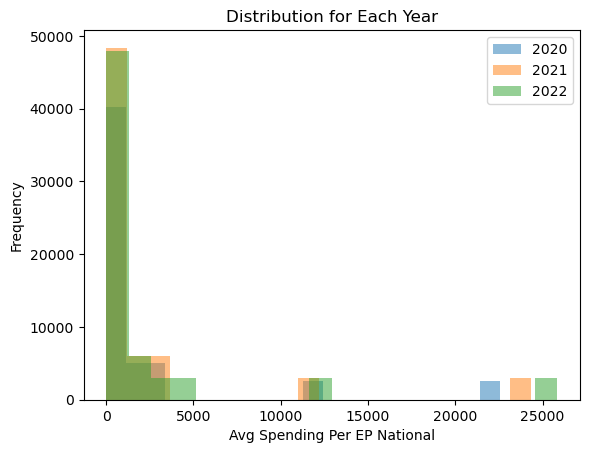

In [9]:
# Plot histograms for Avg Spending Per EP National for each year
import matplotlib.pyplot as plt

plt.hist(medicare_2020['Avg Spndg Per EP National'], bins=20, alpha=0.5, label='2020')
plt.hist(medicare_2021['Avg Spndg Per EP National'], bins=20, alpha=0.5, label='2021')
plt.hist(medicare_2022['Avg Spndg Per EP National'], bins=20, alpha=0.5, label='2022')
plt.xlabel('Avg Spending Per EP National')
plt.ylabel('Frequency')
plt.title('Distribution for Each Year')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2214.090909090909
2348.0


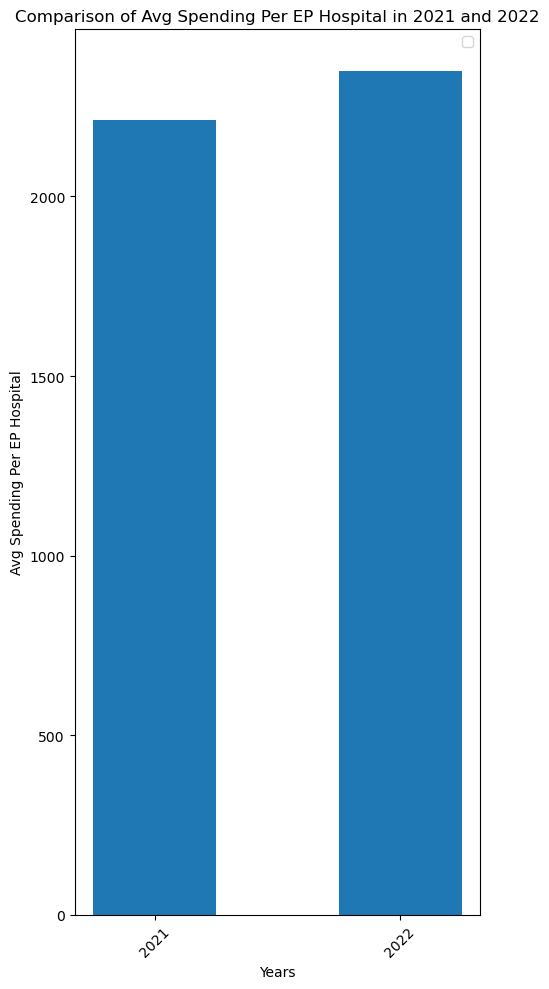

In [22]:

# Calculate average spending per EP hospital for each year
avg_spending_2021 = medicare_2021.groupby('Facility Name')['Avg Spndg Per EP National'].mean().iloc[0]
avg_spending_2022 = medicare_2022.groupby('Facility Name')['Avg Spndg Per EP National'].mean().iloc[0]

print(avg_spending_2021)
print(avg_spending_2022)


# Plot bar graph comparing average spending per EP hospital for 2021 and 2022
plt.figure(figsize=(5, 10))
plt.bar(['2021', '2022'], [avg_spending_2021, avg_spending_2022], align='center', width=0.5)

plt.xlabel('Years')
plt.ylabel('Avg Spending Per EP Hospital')
plt.title('Comparison of Avg Spending Per EP Hospital in 2021 and 2022')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

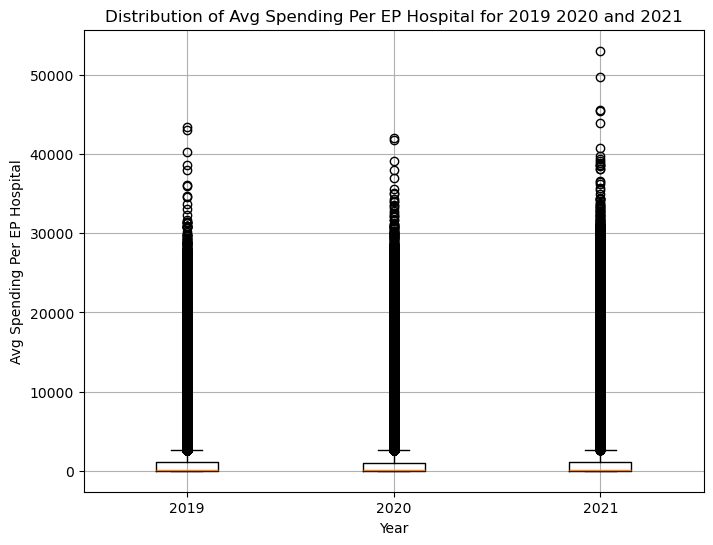

In [20]:
# Combine the datasets for analysis
combined_data = pd.concat([medicare_2019, medicare_2020, medicare_2021])

# Plot boxplot to compare the distribution of average spending per EP hospital for 2019 and 2020
plt.figure(figsize=(8, 6))
plt.boxplot([medicare_2019['Avg Spndg Per EP Hospital'], medicare_2020['Avg Spndg Per EP Hospital'], medicare_2021['Avg Spndg Per EP Hospital']], labels=['2019', '2020', '2021'])
plt.xlabel('Year')
plt.ylabel('Avg Spending Per EP Hospital')
plt.title('Distribution of Avg Spending Per EP Hospital for 2019 2020 and 2021')
plt.grid(True)
plt.show()